In [1]:
import os
import glob
import time
import fitsio
import pylab as pl
import numpy as np
import astropy.io.fits as fits

from   astropy.table import Table, join, hstack, vstack
from   matplotlib import pyplot as plt
from   desitarget.targetmask import zwarn_mask
from   desitarget import targetmask
from   scipy.special import erf

In [2]:
zwarn_mask?

Type:           BitMask
String form:   
zwarn_mask:
           - [SKY,              0, "sky fiber"]
           - [LITTLE_COVERAGE,  1, "too little waveleng <...> to spectrum-level problems"]
           - [BAD_PETALQA,     19, "QA rejected due to petal-level problems"]
File:           /global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/code/desiutil/master/py/desiutil/bitmask.py
Docstring:     
BitMask object to represent bit names, masks, and comments.

Typical users are not expected to create BitMask objects directly;
other packages like desispec and desitarget will have used this
to pre-create the bitmasks for them using definition files in those
packages.

Parameters
----------
name : :class:`str`
    Name of this mask, must be key in `bitdefs`.
bitdefs : :class:`dict`
    Dictionary of different mask bit definitions;
    each value is a list of ``[bitname, bitnum, comment]``.
    A 4th entry is optional, which must be a dictionary.
Init docstring:
Init.
        


In [3]:
ztile_bright = fits.open('/global/cfs/cdirs/desi/spectro/redux/everest/zcatalog/ztile-main-bright-cumulative.fits')

In [4]:
ztile_bright.info()

Filename: /global/cfs/cdirs/desi/spectro/redux/everest/zcatalog/ztile-main-bright-cumulative.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       6   ()      
  1  ZCATALOG      1 BinTableHDU    270   1696000R x 120C   [K, D, 10D, D, D, K, K, 6A, 20A, K, D, I, J, K, J, J, D, D, E, E, E, E, K, B, 3A, E, E, J, D, J, I, J, J, 4A, E, E, E, E, E, E, I, K, 2A, E, E, E, E, 8A, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, 1A, K, K, K, K, K, K, D, D, J, I, E, I, I, E, E, E, E, D, E, D, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E]   
  2  EXP_FIBERMAP    1 BinTableHDU     61   1862000R x 26C   [K, J, D, J, J, D, J, D, I, J, K, J, J, E, E, E, D, D, K, D, D, D, D, D, D, D]   


In [5]:
ztile_bright_expfmap = Table(ztile_bright[2].data)
ztile_bright_expfmap

TARGETID,PRIORITY,SUBPRIORITY,NIGHT,EXPID,MJD,TILEID,EXPTIME,PETAL_LOC,DEVICE_LOC,LOCATION,FIBER,FIBERSTATUS,FIBERASSIGN_X,FIBERASSIGN_Y,LAMBDA_REF,PLATE_RA,PLATE_DEC,NUM_ITER,FIBER_X,FIBER_Y,DELTA_X,DELTA_Y,FIBER_RA,FIBER_DEC,PSF_TO_FIBER_SPECFLUX
int64,int32,float64,int32,int32,float64,int32,float64,int16,int32,int64,int32,int32,float32,float32,float32,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64
39632936659586030,2100,0.8898045796160657,20210514,88385,59349.36647977,20923,399.2758,0,311,311,0,0,80.712036,-287.91705,5400.0,254.02866836295993,32.78814601058069,2,80.708,-287.916,0.008,0.005,254.02870679344207,32.788126404313665,0.7356984740143905
39632936663777376,2100,0.9392995008920402,20210514,88385,59349.36647977,20923,399.2758,0,272,272,1,0,57.371033,-268.13828,5400.0,254.1392079087519,32.86372159877973,2,57.363,-268.139,0.013,0.008,254.1392705376506,32.863690080468345,0.7403908899133331
39632936663779407,2100,0.9538397096587833,20210514,88385,59349.36647977,20923,399.2758,0,252,252,2,0,29.942076,-269.24545,5400.0,254.27084296381005,32.85869525281656,2,29.939,-269.243,0.008,0.006,254.27088146519054,32.85867173820664,0.7553804136761268
39632941747273991,2100,0.36857379932218703,20210514,88385,59349.36647977,20923,399.2758,0,156,156,3,0,4.3957143,-217.3966,5400.0,254.39396195380024,33.0617002810025,2,4.392,-217.383,0.012,-0.004,254.39402014800058,33.061716021218,0.7352785866147586
39632941747275574,2100,0.6416201330389643,20210514,88385,59349.36647977,20923,399.2758,0,198,198,4,0,-15.156455,-254.18259,5400.0,254.48787018988241,32.91679335899171,2,-15.159,-254.172,0.009,-0.001,254.48791356861042,32.91679722724048,0.7388805065065043
39632941743081503,2100,0.8211087472434352,20210514,88385,59349.36647977,20923,399.2758,0,204,204,5,0,44.245037,-236.73672,5400.0,254.20133501903783,32.986063460115055,2,44.245,-236.73,0.006,0.003,254.2013640382045,32.98605150452838,0.774471316719779
39632941743083810,2100,0.9148707509717571,20210514,88385,59349.36647977,20923,399.2758,0,233,233,6,0,12.817468,-260.8199,5400.0,254.3530944469167,32.891162685700344,2,12.815,-260.816,0.008,0.005,254.35313293748635,32.8911430418983,0.7413271050036716
39632941743083238,2100,0.9853411416670134,20210514,88385,59349.36647977,20923,399.2758,0,172,172,7,0,20.680902,-226.05806,5400.0,254.3150593627085,33.027668446679755,2,20.678,-226.047,0.011,-0.001,254.31511258470874,33.02767223285825,0.7535048460904656
39632936659586610,2100,0.9527327827402332,20210514,88385,59349.36647977,20923,399.2758,0,310,310,8,0,73.38342,-292.99805,5400.0,254.0638855980187,32.768310663921774,2,73.376,-293.004,0.011,0.012,254.06393867535988,32.768264060198256,0.7416663211792495


In [6]:
ztile_bright_expfmap['NIGHT'].data.min()

20210514

In [7]:
ztile_bright_expfmap['MONTH'] = [np.int(str(x)[4:6]) for x in ztile_bright_expfmap['NIGHT'].data]

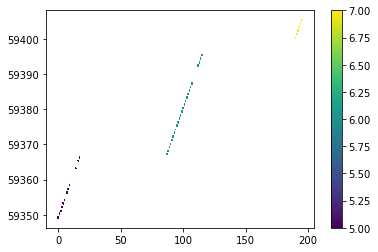

In [8]:
pl.scatter((ztile_bright_expfmap['NIGHT'].data - 20210514), ztile_bright_expfmap['MJD'].data, c=ztile_bright_expfmap['MONTH'].data, marker='.', lw=0.0, s=2)
pl.colorbar()

In [9]:
for month in np.arange(5, 8, 1):
    in_month = ztile_bright_expfmap['MONTH'].data == month
    
    nights   = ztile_bright_expfmap['NIGHT'].data[in_month]
    
    print(month, nights.min(), nights.max())

5 20210514 20210531
6 20210601 20210629
7 20210704 20210709


In [10]:
ztile_bright = Table(ztile_bright[1].data)

In [11]:
# sorted(ztile_bright.dtype.names)

In [12]:
ztile_bright_tiles = Table.read('/global/cfs/cdirs/desi/spectro/redux/everest/tiles-everest.csv')

In [13]:
ztile_bright = join(ztile_bright, ztile_bright_tiles['TILEID', 'EFFTIME_SPEC', 'EFFTIME_ETC'], join_type='left', keys='TILEID')

In [14]:
tiles_daily  = Table.read('/global/cfs/cdirs/desi/spectro/redux/daily/tiles-daily.csv')
tiles_daily  = tiles_daily[tiles_daily['FAFLAVOR'].data == 'mainbright']
tiles_daily  = tiles_daily[tiles_daily['OBSSTATUS'].data == 'obsend']
tiles_daily  = tiles_daily[tiles_daily['LASTNIGHT'].data > 20210709]
tiles_daily.sort('LASTNIGHT')
tiles_daily

TILEID,SURVEY,FAPRGRM,FAFLAVOR,NEXP,EXPTIME,TILERA,TILEDEC,EFFTIME_ETC,EFFTIME_SPEC,EFFTIME_GFA,GOALTIME,OBSSTATUS,LRG_EFFTIME_DARK,ELG_EFFTIME_DARK,BGS_EFFTIME_BRIGHT,LYA_EFFTIME_DARK,GOALTYPE,MINTFRAC,LASTNIGHT
int64,str7,str16,str19,int64,float64,float64,float64,float64,float64,float64,float64,str8,float64,float64,float64,float64,str7,float64,int64
23208,main,bright,mainbright,1,1142.4,325.77,20.772,181.2,334.8,256.7,180.0,obsend,332.5,407.2,334.8,202.2,bright,0.85,20210921
26175,main,bright,mainbright,1,1341.7,68.282,-5.568,181.0,323.6,258.9,180.0,obsend,316.8,385.8,323.6,193.3,bright,0.85,20210921
22402,main,bright,mainbright,1,1240.1,324.316,-2.066,180.5,317.7,270.1,180.0,obsend,311.3,375.4,317.7,202.0,bright,0.85,20210921
22386,main,bright,mainbright,1,1054.1,323.001,1.016,181.6,321.0,267.4,180.0,obsend,314.6,377.9,321.0,212.3,bright,0.85,20210921
22377,main,bright,mainbright,1,1615.5,325.006,3.685,180.5,338.2,249.9,180.0,obsend,333.9,407.7,338.2,178.3,bright,0.85,20210921
24770,main,bright,mainbright,1,986.9,319.928,13.772,89.4,169.8,128.8,180.0,obsend,165.5,199.8,169.8,81.1,bright,0.85,20210921
22372,main,bright,mainbright,1,1212.2,323.694,6.757,181.7,324.7,254.8,180.0,obsend,317.4,382.7,324.7,212.1,bright,0.85,20210921
25606,main,bright,mainbright,1,537.6,271.513,29.574,181.3,274.6,226.3,180.0,obsend,268.2,312.4,274.6,198.7,bright,0.85,20210921
26173,main,bright,mainbright,1,1725.5,71.347,-6.931,180.4,321.0,250.1,180.0,obsend,316.0,390.4,321.0,175.8,bright,0.85,20210921


In [318]:
np.unique(tiles_daily['NEXP'], return_counts=True)

(<Column name='NEXP' dtype='int64' length=4>
 1
 2
 3
 4,
 array([289,  29,   3,   3]))

In [15]:
def grab_redrock(fpath):
    dat = fits.open(fpath)
    
    assert np.all(dat['REDSHIFTS'].data['TARGETID'] == dat['FIBERMAP'].data['TARGETID'])
    assert np.all(dat['REDSHIFTS'].data['TARGETID'] == dat['TSNR2'].data['TARGETID'])
    
    dat = hstack([Table(dat['REDSHIFTS'].data), Table(dat['FIBERMAP'].data), Table(dat['TSNR2'].data)])
    dat['TARGETID'] = dat['TARGETID_1'].data
    
    for i in range(3):
        del dat['TARGETID_{:d}'.format(1+i)]

    return dat

In [16]:
post_shutdown_zcatalog_fpaths = []

for tid in tiles_daily['TILEID'].data:
    fpaths = sorted(glob.glob('/global/cfs/cdirs/desi/spectro/redux/daily/tiles/cumulative/{:d}/*'.format(tid)))
    
    if len(fpaths) > 1:
        nights = np.array([x.split('/')[-1] for x in fpaths]).astype(np.int)
        
        # print(np.sort(nights))
        
        assert np.all(nights == np.sort(nights))
     
    if len(fpaths) > 0:
        fpath = fpaths[-1]
    
    else:
        print('Missing TILEID {:d}'.format(tid))
        
    # print(fpath)
    
    night  = fpath.split('/')[-1]
    
    fpaths = sorted(glob.glob(fpath + '/' + 'redrock-?-{:d}-thru{}.fits'.format(tid, night)))
    '''
    for x in fpaths:
        print(x)
    '''
    post_shutdown_zcatalog_fpaths += [x for x in fpaths]

print('\n\nNumber of redrock fpaths (per petal) to retrieve : {:d}\n\n'.format(len(post_shutdown_zcatalog_fpaths)))
    
post_shutdown_zcatalog = []

start = time.time()

for i, fpath in enumerate(post_shutdown_zcatalog_fpaths):
    if (i % 500) == 0:
        runtime = time.time() - start
        
        print('Completion: {:.6f} [%] after {:.3f} mins.'.format(100. * i / len(post_shutdown_zcatalog_fpaths), runtime / 60.))
    
    post_shutdown_zcatalog.append(grab_redrock(fpath))
    
    # break
    
post_shutdown_zcatalog = vstack(post_shutdown_zcatalog)
post_shutdown_zcatalog

Missing TILEID 23443


Number of redrock fpaths (per petal) to retrieve : 3227


Completion: 0.000000 [%] after 0.000 mins.
Completion: 15.494267 [%] after 0.741 mins.
Completion: 30.988534 [%] after 1.503 mins.
Completion: 46.482801 [%] after 2.272 mins.
Completion: 61.977068 [%] after 3.048 mins.
Completion: 77.471336 [%] after 3.823 mins.
Completion: 92.965603 [%] after 4.616 mins.


CHI2,COEFF [10],Z,ZERR,ZWARN,NPIXELS,SPECTYPE,SUBTYPE,NCOEFF,DELTACHI2,PETAL_LOC,DEVICE_LOC,LOCATION,FIBER,COADD_FIBERSTATUS,TARGET_RA,TARGET_DEC,PMRA,PMDEC,REF_EPOCH,LAMBDA_REF,FA_TARGET,FA_TYPE,OBJTYPE,FIBERASSIGN_X,FIBERASSIGN_Y,PRIORITY,SUBPRIORITY,OBSCONDITIONS,RELEASE,BRICKNAME,BRICKID,BRICK_OBJID,MORPHTYPE,EBV,FLUX_G,FLUX_R,FLUX_Z,FLUX_W1,FLUX_W2,FLUX_IVAR_G,FLUX_IVAR_R,FLUX_IVAR_Z,FLUX_IVAR_W1,FLUX_IVAR_W2,FIBERFLUX_G,FIBERFLUX_R,FIBERFLUX_Z,FIBERTOTFLUX_G,FIBERTOTFLUX_R,FIBERTOTFLUX_Z,MASKBITS,SERSIC,SHAPE_R,SHAPE_E1,SHAPE_E2,REF_ID,REF_CAT,GAIA_PHOT_G_MEAN_MAG,GAIA_PHOT_BP_MEAN_MAG,GAIA_PHOT_RP_MEAN_MAG,PARALLAX,PHOTSYS,PRIORITY_INIT,NUMOBS_INIT,DESI_TARGET,BGS_TARGET,MWS_TARGET,SCND_TARGET,PLATE_RA,PLATE_DEC,TILEID,COADD_NUMEXP,COADD_EXPTIME,COADD_NUMNIGHT,COADD_NUMTILE,MEAN_DELTA_X,RMS_DELTA_X,MEAN_DELTA_Y,RMS_DELTA_Y,MEAN_FIBER_RA,STD_FIBER_RA,MEAN_FIBER_DEC,STD_FIBER_DEC,MEAN_PSF_TO_FIBER_SPECFLUX,MEAN_FIBER_X,MEAN_FIBER_Y,TSNR2_GPBDARK_B,TSNR2_ELG_B,TSNR2_GPBBRIGHT_B,TSNR2_LYA_B,TSNR2_BGS_B,TSNR2_GPBBACKUP_B,TSNR2_QSO_B,TSNR2_LRG_B,TSNR2_GPBDARK_R,TSNR2_ELG_R,TSNR2_GPBBRIGHT_R,TSNR2_LYA_R,TSNR2_BGS_R,TSNR2_GPBBACKUP_R,TSNR2_QSO_R,TSNR2_LRG_R,TSNR2_GPBDARK_Z,TSNR2_ELG_Z,TSNR2_GPBBRIGHT_Z,TSNR2_LYA_Z,TSNR2_BGS_Z,TSNR2_GPBBACKUP_Z,TSNR2_QSO_Z,TSNR2_LRG_Z,TSNR2_GPBDARK,TSNR2_ELG,TSNR2_GPBBRIGHT,TSNR2_LYA,TSNR2_BGS,TSNR2_GPBBACKUP,TSNR2_QSO,TSNR2_LRG,TARGETID
float64,float64,float64,float64,int64,int64,str6,str20,int64,float64,int16,int32,int64,int32,int32,float64,float64,float32,float32,float32,float32,int64,uint8,str3,float32,float32,int32,float64,int32,int16,str8,int32,int32,str4,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,float32,float32,float32,float32,int64,str2,float32,float32,float32,float32,str1,int64,int64,int64,int64,int64,int64,float64,float64,int32,int16,float32,int16,int16,float32,float32,float32,float32,float64,float32,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64
7368.512324050069,102.31315082050442 .. -11.612822574758441,0.5482287178620497,7.6684803132841e-05,5,7849,GALAXY,,10,6.691026587039232,0,311,311,0,0,325.4279535854757,19.608472996303934,0.0,0.0,0.0,5400.0,4294967296,4,SKY,79.79592,-289.58105,-1,0.9687008821754699,63,9010,3254p195,441915,1106,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.011383131,0.0008564105,0.047567077,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,,0.0,0.0,0.0,0.0,,-1,-1,4294967296,0,0,0,325.4279535854757,19.608472996303934,23208,1,1142.356,1,1,0.005,0.005,0.0,0.0,325.427974848516,0.0,19.60847278292847,0.0,0.7920889,79.804,-289.595,64.47068,0.028962497,12.171512,27.442316,156.49649,117.588524,0.81647676,0.28611872,4170.3125,9.248393,779.4531,0.01926647,904.42755,7265.1084,2.9931254,13.1013565,1.0626695e-05,44.42079,1.9873212e-06,0.0,1929.0763,1.8565588e-05,9.642146,19.80331,4234.783,53.698147,791.62463,27.461582,2990.0005,7382.697,13.451748,33.190784,616089004894323794
7491.6369546204805,59.67886247418766 .. 17.678228349411217,0.11439713351643592,9.960681533954102e-06,0,7834,GALAXY,,10,296.9622937887907,0,272,272,1,0,325.49921449729794,19.681495466895377,0.0,0.0,2015.5,5400.0,5764607523034234880,1,TGT,62.869656,-270.49844,2100,0.6913926715532083,575,9010,3254p197,443273,7141,SER,0.10994332,9.638242,17.853682,29.805294,24.912931,12.403942,366.63654,97.99554,9.679754,2.0611663,0.58678883,1.3731658,2.5436242,4.246377,1.3731658,2.5436242,4.246377,2048,0.6197248,3.0255368,-0.049006183,0.6689101,0,,0.0,0.0,0.0,0.0,S,2100,2,5764607523034234880,131074,0,131072,325.49921449729794,19.681495466895377,23208,1,1142.356,1,1,0.005,0.005,-0.002,0.002,325.49923579071793,0.0,19.681503078134078,0.0,0.7407353,62.873,-270.508,41.819016,0.016449064,7.8830843,1

In [312]:
dat = fits.open(post_shutdown_zcatalog_fpaths[0])
dat['FIBERMAP'].data.dtype.names

('TARGETID',
 'PETAL_LOC',
 'DEVICE_LOC',
 'LOCATION',
 'FIBER',
 'COADD_FIBERSTATUS',
 'TARGET_RA',
 'TARGET_DEC',
 'PMRA',
 'PMDEC',
 'REF_EPOCH',
 'LAMBDA_REF',
 'FA_TARGET',
 'FA_TYPE',
 'OBJTYPE',
 'FIBERASSIGN_X',
 'FIBERASSIGN_Y',
 'PRIORITY',
 'SUBPRIORITY',
 'OBSCONDITIONS',
 'RELEASE',
 'BRICKNAME',
 'BRICKID',
 'BRICK_OBJID',
 'MORPHTYPE',
 'EBV',
 'FLUX_G',
 'FLUX_R',
 'FLUX_Z',
 'FLUX_W1',
 'FLUX_W2',
 'FLUX_IVAR_G',
 'FLUX_IVAR_R',
 'FLUX_IVAR_Z',
 'FLUX_IVAR_W1',
 'FLUX_IVAR_W2',
 'FIBERFLUX_G',
 'FIBERFLUX_R',
 'FIBERFLUX_Z',
 'FIBERTOTFLUX_G',
 'FIBERTOTFLUX_R',
 'FIBERTOTFLUX_Z',
 'MASKBITS',
 'SERSIC',
 'SHAPE_R',
 'SHAPE_E1',
 'SHAPE_E2',
 'REF_ID',
 'REF_CAT',
 'GAIA_PHOT_G_MEAN_MAG',
 'GAIA_PHOT_BP_MEAN_MAG',
 'GAIA_PHOT_RP_MEAN_MAG',
 'PARALLAX',
 'PHOTSYS',
 'PRIORITY_INIT',
 'NUMOBS_INIT',
 'DESI_TARGET',
 'BGS_TARGET',
 'MWS_TARGET',
 'SCND_TARGET',
 'PLATE_RA',
 'PLATE_DEC',
 'TILEID',
 'COADD_NUMEXP',
 'COADD_EXPTIME',
 'COADD_NUMNIGHT',
 'COADD_NUMTILE',
 '

In [17]:
sorted(post_shutdown_zcatalog.dtype.names) == sorted(ztile_bright.dtype.names)

False

In [18]:
np.mean(np.isin(tiles_daily['TILEID'].data, np.unique(post_shutdown_zcatalog['TILEID'].data)))

0.9969135802469136

In [19]:
len(post_shutdown_zcatalog) / 1.e6, len(ztile_bright) / 1.e6

(1.6135, 1.696)

In [20]:
post_shutdown_zcatalog = join(post_shutdown_zcatalog, tiles_daily['TILEID', 'EFFTIME_SPEC', 'EFFTIME_ETC'], join_type='left', keys='TILEID')

In [21]:
ztile_bright = vstack([post_shutdown_zcatalog, ztile_bright])

In [270]:
ztile_bright['SURVEYSPEED']     = ztile_bright['EFFTIME_SPEC'] / ztile_bright['COADD_EXPTIME']
ztile_bright['SURVEYSPEED_ETC'] = ztile_bright['EFFTIME_ETC']  / ztile_bright['COADD_EXPTIME']

<ipython-input-270-4e77b3cf6c5e>:1: RuntimeWarning: divide by zero encountered in true_divide
  ztile_bright['SURVEYSPEED']     = ztile_bright['EFFTIME_SPEC'] / ztile_bright['COADD_EXPTIME']
<ipython-input-270-4e77b3cf6c5e>:2: RuntimeWarning: divide by zero encountered in true_divide
  ztile_bright['SURVEYSPEED_ETC'] = ztile_bright['EFFTIME_ETC']  / ztile_bright['COADD_EXPTIME']


In [271]:
ztile_bright = ztile_bright[ztile_bright['COADD_FIBERSTATUS'].data == 0]

In [272]:
ztile_bright

CHI2,COEFF [10],Z,ZERR,ZWARN,NPIXELS,SPECTYPE,SUBTYPE,NCOEFF,DELTACHI2,PETAL_LOC,DEVICE_LOC,LOCATION,FIBER,COADD_FIBERSTATUS,TARGET_RA,TARGET_DEC,PMRA,PMDEC,REF_EPOCH,LAMBDA_REF,FA_TARGET,FA_TYPE,OBJTYPE,FIBERASSIGN_X,FIBERASSIGN_Y,PRIORITY,SUBPRIORITY,OBSCONDITIONS,RELEASE,BRICKNAME,BRICKID,BRICK_OBJID,MORPHTYPE,EBV,FLUX_G,FLUX_R,FLUX_Z,FLUX_W1,FLUX_W2,FLUX_IVAR_G,FLUX_IVAR_R,FLUX_IVAR_Z,FLUX_IVAR_W1,FLUX_IVAR_W2,FIBERFLUX_G,FIBERFLUX_R,FIBERFLUX_Z,FIBERTOTFLUX_G,FIBERTOTFLUX_R,FIBERTOTFLUX_Z,MASKBITS,SERSIC,SHAPE_R,SHAPE_E1,SHAPE_E2,REF_ID,REF_CAT,GAIA_PHOT_G_MEAN_MAG,GAIA_PHOT_BP_MEAN_MAG,GAIA_PHOT_RP_MEAN_MAG,PARALLAX,PHOTSYS,PRIORITY_INIT,NUMOBS_INIT,DESI_TARGET,BGS_TARGET,MWS_TARGET,SCND_TARGET,PLATE_RA,PLATE_DEC,TILEID,COADD_NUMEXP,COADD_EXPTIME,COADD_NUMNIGHT,COADD_NUMTILE,MEAN_DELTA_X,RMS_DELTA_X,MEAN_DELTA_Y,RMS_DELTA_Y,MEAN_FIBER_RA,STD_FIBER_RA,MEAN_FIBER_DEC,STD_FIBER_DEC,MEAN_PSF_TO_FIBER_SPECFLUX,MEAN_FIBER_X,MEAN_FIBER_Y,TSNR2_GPBDARK_B,TSNR2_ELG_B,TSNR2_GPBBRIGHT_B,TSNR2_LYA_B,TSNR2_BGS_B,TSNR2_GPBBACKUP_B,TSNR2_QSO_B,TSNR2_LRG_B,TSNR2_GPBDARK_R,TSNR2_ELG_R,TSNR2_GPBBRIGHT_R,TSNR2_LYA_R,TSNR2_BGS_R,TSNR2_GPBBACKUP_R,TSNR2_QSO_R,TSNR2_LRG_R,TSNR2_GPBDARK_Z,TSNR2_ELG_Z,TSNR2_GPBBRIGHT_Z,TSNR2_LYA_Z,TSNR2_BGS_Z,TSNR2_GPBBACKUP_Z,TSNR2_QSO_Z,TSNR2_LRG_Z,TSNR2_GPBDARK,TSNR2_ELG,TSNR2_GPBBRIGHT,TSNR2_LYA,TSNR2_BGS,TSNR2_GPBBACKUP,TSNR2_QSO,TSNR2_LRG,TARGETID,EFFTIME_SPEC,EFFTIME_ETC,SURVEYSPEED,POSTSHUTDOWN,SURVEYSPEED_ETC
float64,float64,float64,float64,int64,int64,str6,str20,int64,float64,int16,int32,int64,int32,int32,float64,float64,float32,float32,float32,float32,int64,uint8,str3,float32,float32,int32,float64,int32,int16,str8,int32,int32,str4,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,float32,float32,float32,float32,int64,str2,float32,float32,float32,float32,str1,int64,int64,int64,int64,int64,int64,float64,float64,int64,int16,float32,int16,int16,float32,float32,float32,float32,float64,float32,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,float64,float64,float64,bool,float64
7800.926482796669,363.9800738206797 .. -1.5142543135915874,0.199278152375892,6.242175473369144e-06,0,7859,GALAXY,,10,1109.810787320137,0,232,232,41,0,20.87644192161398,-1.0728837562288407,0.0,0.0,2015.5,5400.0,1152921504606846976,1,TGT,7.2610765,-265.5939,2100,0.674576326760455,516,9010,0208m010,324691,4121,REX,0.057417,8.444731,14.246235,20.057777,16.899956,7.336151,814.3917,400.0642,49.546703,2.3797443,0.56499714,2.482372,4.187754,5.8960867,2.4825463,4.188116,5.896402,0,1.0,0.96088624,0.0,0.0,0,,0.0,0.0,0.0,0.0,S,2100,2,1152921504606846976,131074,0,0,20.87644192161398,-1.0728837562288407,20006,1,511.9939,1,1,-0.004,0.004,-0.003,0.003,20.876425744646077,0.0,-1.07287205844679,0.0,0.7590076,7.266,-265.618,34.70489,0.016860858,6.4727473,13.845164,92.2237,56.900623,0.46470886,0.17023173,2368.8923,4.9797616,434.18842,0.010113622,509.95956,3609.4949,1.6249684,7.233866,4.622141e-06,18.428215,8.613623e-07,0.0,891.7391,7.561006e-06,4.106878,8.790722,2403.5972,23.424837,440.66116,13.855278,1493.9224,3666.3955,6.196555,16.19482,39627760917811225,235.1,184.6,0.4591851614136864,True,0.36055117310491924
7770.324475061148,293.69117374359837 .. -22.432343256647655,0.2231878652008735,4.4333995645173435e-05,0,7835,GALAXY,,10,124.07587506063282,6,125,6125,3378,0,21.230510758771715,0.8558626330172106,0.0,0.0,2015.5,5400.0,1152921504606846976,1,TGT,-80.33284,210.72232,2100,0.9749558482099647,516,9010,0211p007,334772,8340,SER,0.030862385,8.116339,22.037558,42.095955,43.343273,33.840565,674.3588,326.92963,53.419086,1.7809582,0.44540167,2.1415355,5.814717,11.107223,2.1455889,5.817591,11.107536,0,2.364232,2.0286763,0.

In [273]:
len(ztile_bright) / 1.e6

2.746012

In [274]:
# ztile_bright.dtype.names

In [275]:
ztile_bright['POSTSHUTDOWN'] = np.isin(ztile_bright['TILEID'].data, tiles_daily['TILEID'].data)

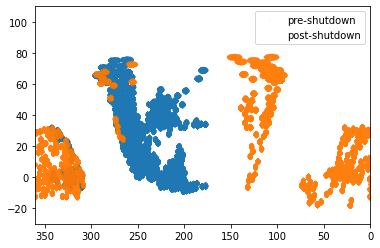

In [276]:
pl.plot(ztile_bright['TARGET_RA'].data[~ztile_bright['POSTSHUTDOWN']], ztile_bright['TARGET_DEC'].data[~ztile_bright['POSTSHUTDOWN']], marker='.', lw=0.0, alpha=0.1, label='pre-shutdown', markersize=1)
pl.plot(ztile_bright['TARGET_RA'].data[ztile_bright['POSTSHUTDOWN']],  ztile_bright['TARGET_DEC'].data[ztile_bright['POSTSHUTDOWN']], marker='.', lw=0.0, alpha=0.1, label='post-shutdown', markersize=1)

pl.xlim(360., 0.0)
pl.ylim(-30., 110.0)

pl.legend(loc=1)

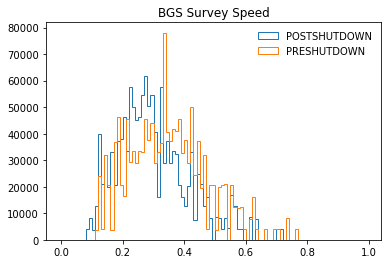

In [277]:
ps = ztile_bright['POSTSHUTDOWN'].data

_  = plt.hist(ztile_bright['SURVEYSPEED'].data[ps],  bins=np.arange(0.0, 1.0, 0.01), histtype='step', label='POSTSHUTDOWN')
_  = plt.hist(ztile_bright['SURVEYSPEED'].data[~ps], bins=np.arange(0.0, 1.0, 0.01), histtype='step', label='PRESHUTDOWN')

plt.title('BGS Survey Speed')
plt.legend(frameon=False)

In [278]:
is_bgs = ztile_bright['DESI_TARGET'] & targetmask.desi_mask['BGS_ANY'] > 0

ztile_bgs = ztile_bright[is_bgs]

In [280]:
# sorted(ztile_bgs.dtype.names)

In [281]:
len(ztile_bgs) / 1.e6

2.108829

In [282]:
ztile_bgsbright = ztile_bgs[ztile_bgs['BGS_TARGET'] & targetmask.bgs_mask['BGS_BRIGHT'] > 0]
ztile_bgsfaint  = ztile_bgs[ztile_bgs['BGS_TARGET'] & targetmask.bgs_mask['BGS_FAINT']  > 0]

In [283]:
len(ztile_bgsbright) / 1.e6, len(ztile_bgsfaint) / 1.e6

(1.575291, 0.530963)

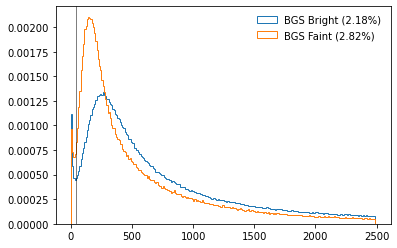

In [284]:
failfrac_bgsbright = 100. * np.mean(ztile_bgsbright['DELTACHI2'].data < 40.)
failfrac_bgsfaint  = 100. * np.mean(ztile_bgsfaint['DELTACHI2'].data  < 40.)

_ = pl.hist(ztile_bgsbright['DELTACHI2'].data, bins=np.arange(0.0, 2500., 10.), histtype='step', label='BGS Bright ({:.2f}%)'.format(failfrac_bgsbright), density=True)
_ = pl.hist(ztile_bgsfaint['DELTACHI2'].data,  bins=np.arange(0.0, 2500., 10.), histtype='step', label='BGS Faint ({:.2f}%)'.format(failfrac_bgsfaint), density=True)

pl.axvline(40., c='k', lw=0.5)
pl.legend(loc=1, frameon=False)

In [285]:
def bgs_success(cat, dX2=40.):
    success  = (cat['ZWARN'].data == 0) 
    success &= (cat['DELTACHI2'].data > dX2)
    success &= (cat['Z'].data < 0.6)
    
    return success

In [286]:
100. - np.mean(bgs_success(ztile_bgsbright))

99.02485382065916

In [287]:
ztile_bgsbright['ZSUCCESS'] = bgs_success(ztile_bgsbright)
ztile_bgsfaint['ZSUCCESS']  = bgs_success(ztile_bgsfaint)

In [288]:
100. * np.mean(ztile_bgsbright['ZSUCCESS'])

97.51461793408329

In [289]:
100. * np.mean(ztile_bgsfaint['ZSUCCESS'])

96.23740260620797

In [291]:
# set minimum/maximum TSNR2_LRG for the rest of the plots
limits = {'TSNR2_BGS': (0, 16000), 'SURVEYSPEED': (0., 1.), 'SURVEYSPEED_ETC': (0., 1.)}

In [292]:
def tsnr_zfrac(cat, ttype, sel=None, title='', xaxis='TSNR2_BGS', nbins=50):
    cat      = Table(cat, copy=True)
    
    if sel == None:
        selrate = 1.0

    else:
        selrate = np.mean(sel(cat))
    
    if sel != None:
        cat  = cat[sel(cat)] 
        
    ntot, tb = np.histogram(cat[xaxis], bins=nbins, range=limits[xaxis])
    ng, _    = np.histogram(cat[xaxis][cat['ZSUCCESS'] == True], bins=tb, range=limits[xaxis])

    step     = tb[1]-tb[0]
    bl       = tb[:-1] + step/2.
    zfrac    = ng / ntot 
    
    varl     = zfrac * ntot * (1.-zfrac)
    wv       = (varl == 0)

    # print(np.mean(wv))

    varl[wv] = 1.
 
    el       = np.sqrt(varl) / ntot

    ###############################    
    fig, axes = plt.subplots(2, 1, figsize=(8, 6), dpi=80, gridspec_kw={'height_ratios': [3, 1]})    
        
    axes[0].errorbar(bl, ng / ntot, el, fmt='o', label='Main Survey BGS {}'.format(ttype), markersize=3)
    axes[0].legend(frameon=False, loc=3)

    ymin     = zfrac[np.isfinite(zfrac) & ~wv].min() - 0.1    
    axes[0].set_xlim(tb.min(), tb.max())
    axes[0].set_ylim(ymin, 1.05)

    title = title + '  ({:.3f}% selection at {:.3f}% z-success)'.format(100. * selrate, 100. * np.mean(cat['ZSUCCESS'].data))    
    axes[0].set_title(title)
    
    axes[1].hist(cat[xaxis], density=True, bins=nbins, range=limits[xaxis], histtype='step')
    axes[1].set_xlim(tb.min(), tb.max())
    axes[1].set_xlabel(xaxis)
    # axes[1].set_yscale('log')
    
    for hh in np.arange(0.95, 1.00, 0.01):
        axes[0].axhline(hh, lw=0.2, c='g')
        
    for hh in np.arange(0.90, 0.95, 0.01):
        axes[0].axhline(hh, lw=0.2, c='r')
        
    plt.show()

In [293]:
post_shutdown = lambda cat:  cat['POSTSHUTDOWN'].data
good_petal    = lambda cat:  ~np.isin(cat['PETAL_LOC'].data, [1, 4, 5, 8])

post_shutdown_and_good_petal = lambda cat: post_shutdown(cat) & good_petal(cat) 

<ipython-input-292-be075ee2c30a>:18: RuntimeWarning: invalid value encountered in true_divide
  zfrac    = ng / ntot
<ipython-input-292-be075ee2c30a>:32: RuntimeWarning: invalid value encountered in true_divide
  axes[0].errorbar(bl, ng / ntot, el, fmt='o', label='Main Survey BGS {}'.format(ttype), markersize=3)


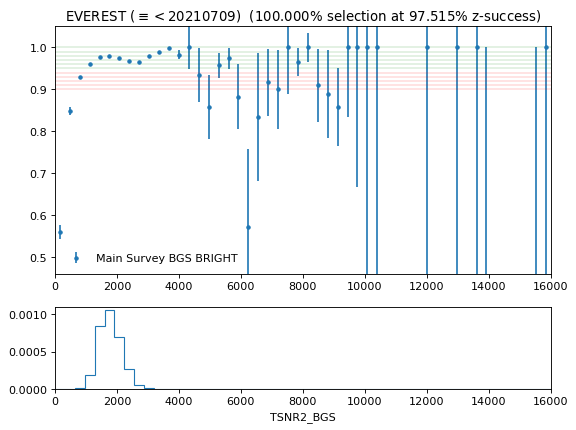

<ipython-input-292-be075ee2c30a>:18: RuntimeWarning: invalid value encountered in true_divide
  zfrac    = ng / ntot
<ipython-input-292-be075ee2c30a>:32: RuntimeWarning: invalid value encountered in true_divide
  axes[0].errorbar(bl, ng / ntot, el, fmt='o', label='Main Survey BGS {}'.format(ttype), markersize=3)


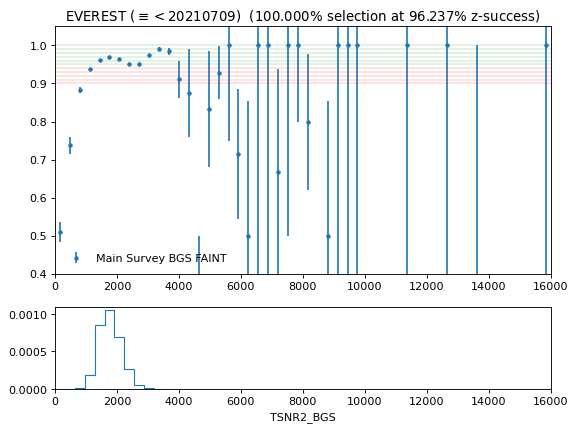

In [294]:
tsnr_zfrac(ztile_bgsbright, 'BRIGHT', title=r'EVEREST ($\equiv < 20210709$)')
tsnr_zfrac(ztile_bgsfaint,   'FAINT', title=r'EVEREST ($\equiv < 20210709$)')

<ipython-input-292-be075ee2c30a>:18: RuntimeWarning: invalid value encountered in true_divide
  zfrac    = ng / ntot
<ipython-input-292-be075ee2c30a>:32: RuntimeWarning: invalid value encountered in true_divide
  axes[0].errorbar(bl, ng / ntot, el, fmt='o', label='Main Survey BGS {}'.format(ttype), markersize=3)


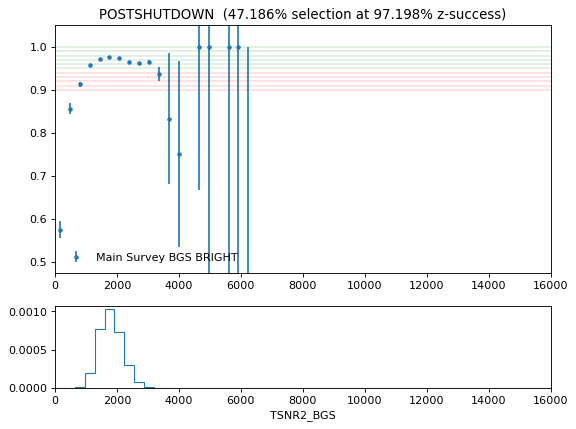

<ipython-input-292-be075ee2c30a>:18: RuntimeWarning: invalid value encountered in true_divide
  zfrac    = ng / ntot
<ipython-input-292-be075ee2c30a>:32: RuntimeWarning: invalid value encountered in true_divide
  axes[0].errorbar(bl, ng / ntot, el, fmt='o', label='Main Survey BGS {}'.format(ttype), markersize=3)


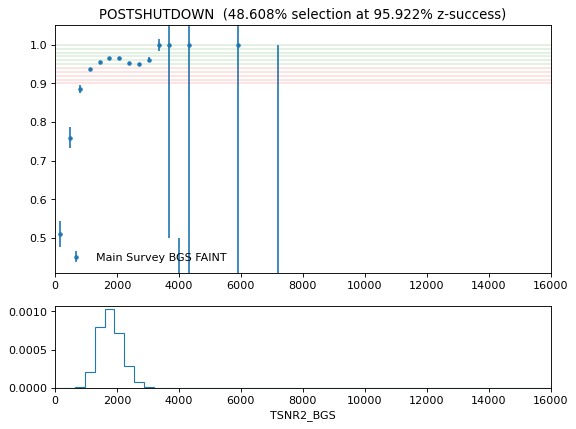

In [295]:
tsnr_zfrac(ztile_bgsbright, 'BRIGHT', sel=post_shutdown, title='POSTSHUTDOWN')
tsnr_zfrac(ztile_bgsfaint, 'FAINT', sel=post_shutdown, title='POSTSHUTDOWN')

<ipython-input-292-be075ee2c30a>:18: RuntimeWarning: invalid value encountered in true_divide
  zfrac    = ng / ntot
<ipython-input-292-be075ee2c30a>:32: RuntimeWarning: invalid value encountered in true_divide
  axes[0].errorbar(bl, ng / ntot, el, fmt='o', label='Main Survey BGS {}'.format(ttype), markersize=3)


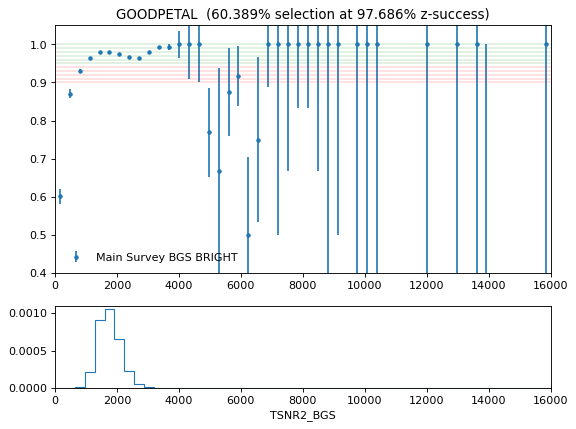

<ipython-input-292-be075ee2c30a>:18: RuntimeWarning: invalid value encountered in true_divide
  zfrac    = ng / ntot
<ipython-input-292-be075ee2c30a>:32: RuntimeWarning: invalid value encountered in true_divide
  axes[0].errorbar(bl, ng / ntot, el, fmt='o', label='Main Survey BGS {}'.format(ttype), markersize=3)


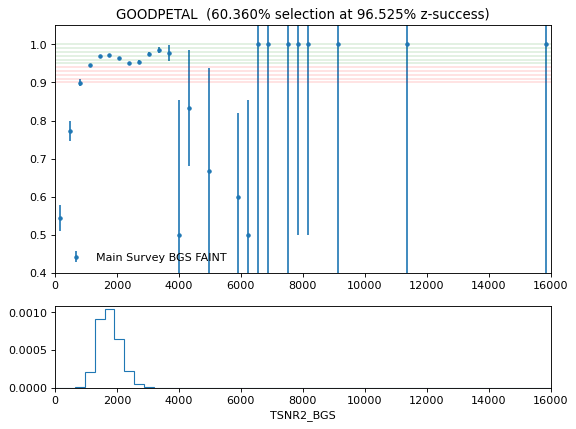

In [296]:
tsnr_zfrac(ztile_bgsbright, 'BRIGHT', sel=good_petal, title='GOODPETAL')
tsnr_zfrac(ztile_bgsfaint, 'FAINT', sel=good_petal, title='GOODPETAL')

<ipython-input-292-be075ee2c30a>:18: RuntimeWarning: invalid value encountered in true_divide
  zfrac    = ng / ntot
<ipython-input-292-be075ee2c30a>:32: RuntimeWarning: invalid value encountered in true_divide
  axes[0].errorbar(bl, ng / ntot, el, fmt='o', label='Main Survey BGS {}'.format(ttype), markersize=3)


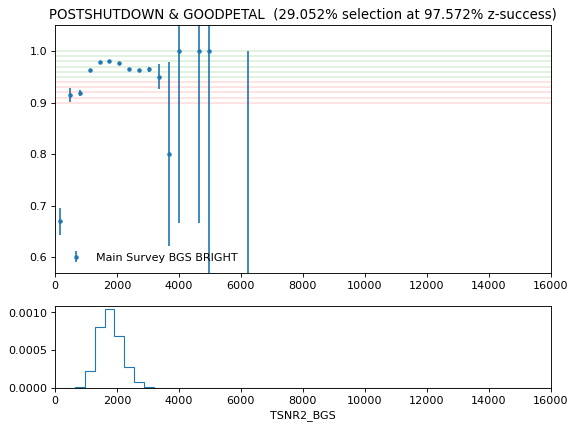

<ipython-input-292-be075ee2c30a>:18: RuntimeWarning: invalid value encountered in true_divide
  zfrac    = ng / ntot
<ipython-input-292-be075ee2c30a>:32: RuntimeWarning: invalid value encountered in true_divide
  axes[0].errorbar(bl, ng / ntot, el, fmt='o', label='Main Survey BGS {}'.format(ttype), markersize=3)


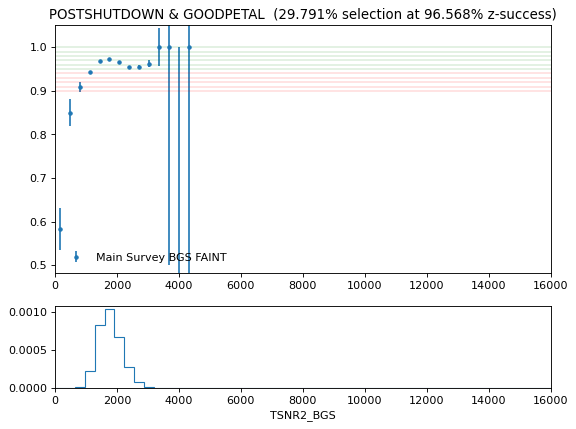

In [297]:
tsnr_zfrac(ztile_bgsbright, 'BRIGHT', sel=post_shutdown_and_good_petal, title='POSTSHUTDOWN & GOODPETAL')
tsnr_zfrac(ztile_bgsfaint, 'FAINT', sel=post_shutdown_and_good_petal, title='POSTSHUTDOWN & GOODPETAL')

<ipython-input-292-be075ee2c30a>:18: RuntimeWarning: invalid value encountered in true_divide
  zfrac    = ng / ntot
<ipython-input-292-be075ee2c30a>:32: RuntimeWarning: invalid value encountered in true_divide
  axes[0].errorbar(bl, ng / ntot, el, fmt='o', label='Main Survey BGS {}'.format(ttype), markersize=3)


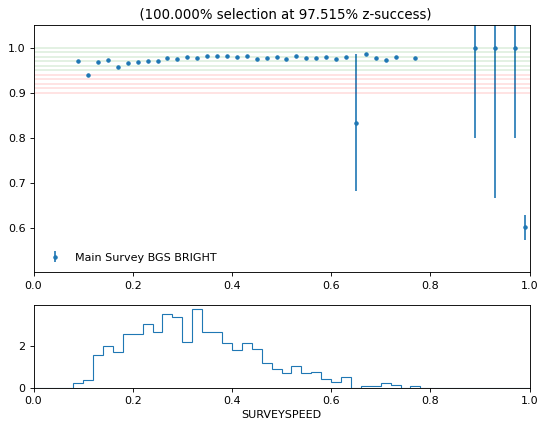

<ipython-input-292-be075ee2c30a>:18: RuntimeWarning: invalid value encountered in true_divide
  zfrac    = ng / ntot
<ipython-input-292-be075ee2c30a>:32: RuntimeWarning: invalid value encountered in true_divide
  axes[0].errorbar(bl, ng / ntot, el, fmt='o', label='Main Survey BGS {}'.format(ttype), markersize=3)


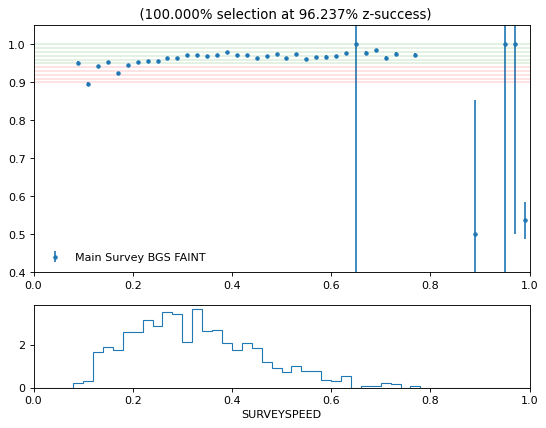

In [298]:
tsnr_zfrac(ztile_bgsbright, 'BRIGHT', xaxis='SURVEYSPEED')
tsnr_zfrac(ztile_bgsfaint,   'FAINT', xaxis='SURVEYSPEED')

<ipython-input-292-be075ee2c30a>:18: RuntimeWarning: invalid value encountered in true_divide
  zfrac    = ng / ntot
<ipython-input-292-be075ee2c30a>:32: RuntimeWarning: invalid value encountered in true_divide
  axes[0].errorbar(bl, ng / ntot, el, fmt='o', label='Main Survey BGS {}'.format(ttype), markersize=3)


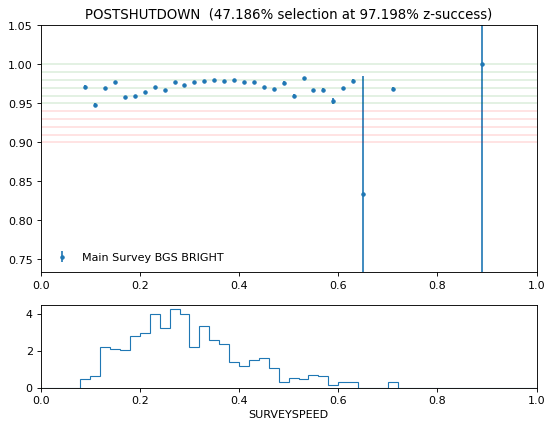

<ipython-input-292-be075ee2c30a>:18: RuntimeWarning: invalid value encountered in true_divide
  zfrac    = ng / ntot
<ipython-input-292-be075ee2c30a>:32: RuntimeWarning: invalid value encountered in true_divide
  axes[0].errorbar(bl, ng / ntot, el, fmt='o', label='Main Survey BGS {}'.format(ttype), markersize=3)


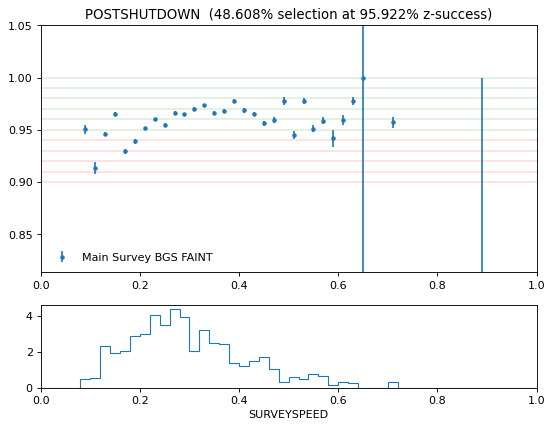

In [299]:
tsnr_zfrac(ztile_bgsbright, 'BRIGHT', sel=post_shutdown, title='POSTSHUTDOWN', xaxis='SURVEYSPEED')
tsnr_zfrac(ztile_bgsfaint, 'FAINT', sel=post_shutdown, title='POSTSHUTDOWN', xaxis='SURVEYSPEED')

<ipython-input-292-be075ee2c30a>:18: RuntimeWarning: invalid value encountered in true_divide
  zfrac    = ng / ntot
<ipython-input-292-be075ee2c30a>:32: RuntimeWarning: invalid value encountered in true_divide
  axes[0].errorbar(bl, ng / ntot, el, fmt='o', label='Main Survey BGS {}'.format(ttype), markersize=3)


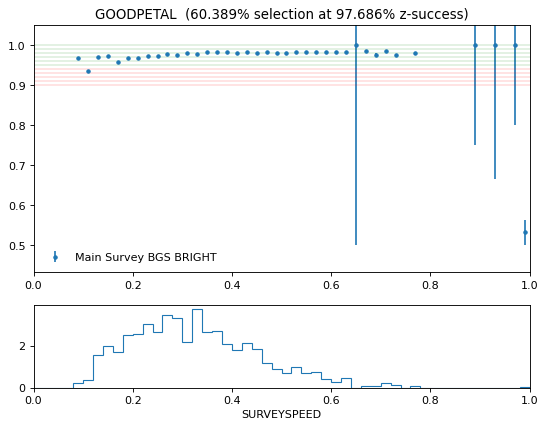

<ipython-input-292-be075ee2c30a>:18: RuntimeWarning: invalid value encountered in true_divide
  zfrac    = ng / ntot
<ipython-input-292-be075ee2c30a>:32: RuntimeWarning: invalid value encountered in true_divide
  axes[0].errorbar(bl, ng / ntot, el, fmt='o', label='Main Survey BGS {}'.format(ttype), markersize=3)


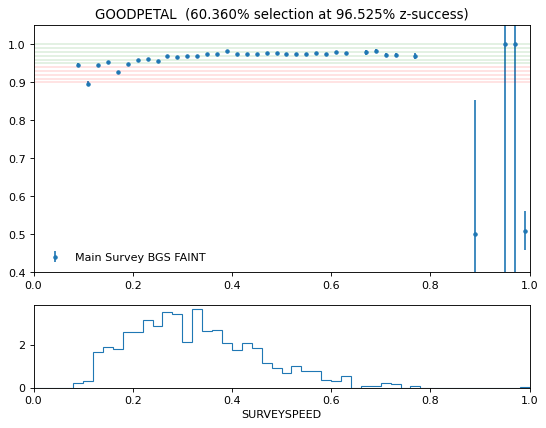

In [300]:
tsnr_zfrac(ztile_bgsbright, 'BRIGHT', sel=good_petal, title='GOODPETAL', xaxis='SURVEYSPEED')
tsnr_zfrac(ztile_bgsfaint, 'FAINT', sel=good_petal, title='GOODPETAL', xaxis='SURVEYSPEED')

<ipython-input-292-be075ee2c30a>:18: RuntimeWarning: invalid value encountered in true_divide
  zfrac    = ng / ntot
<ipython-input-292-be075ee2c30a>:32: RuntimeWarning: invalid value encountered in true_divide
  axes[0].errorbar(bl, ng / ntot, el, fmt='o', label='Main Survey BGS {}'.format(ttype), markersize=3)


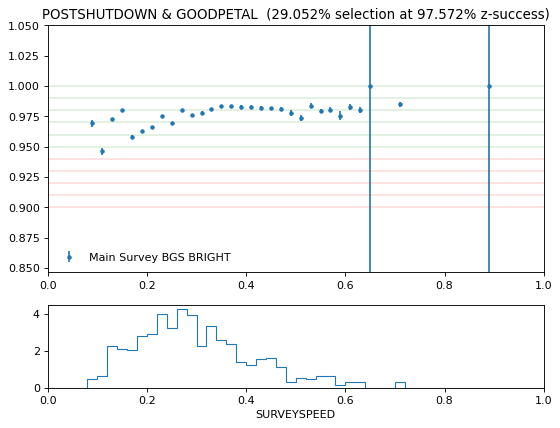

<ipython-input-292-be075ee2c30a>:18: RuntimeWarning: invalid value encountered in true_divide
  zfrac    = ng / ntot
<ipython-input-292-be075ee2c30a>:32: RuntimeWarning: invalid value encountered in true_divide
  axes[0].errorbar(bl, ng / ntot, el, fmt='o', label='Main Survey BGS {}'.format(ttype), markersize=3)


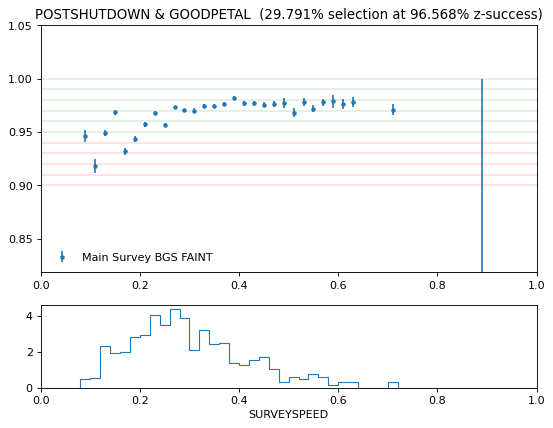

In [301]:
tsnr_zfrac(ztile_bgsbright, 'BRIGHT', sel=post_shutdown_and_good_petal, title='POSTSHUTDOWN & GOODPETAL', xaxis='SURVEYSPEED')
tsnr_zfrac(ztile_bgsfaint, 'FAINT', sel=post_shutdown_and_good_petal, title='POSTSHUTDOWN & GOODPETAL', xaxis='SURVEYSPEED')

<ipython-input-292-be075ee2c30a>:18: RuntimeWarning: invalid value encountered in true_divide
  zfrac    = ng / ntot
<ipython-input-292-be075ee2c30a>:32: RuntimeWarning: invalid value encountered in true_divide
  axes[0].errorbar(bl, ng / ntot, el, fmt='o', label='Main Survey BGS {}'.format(ttype), markersize=3)


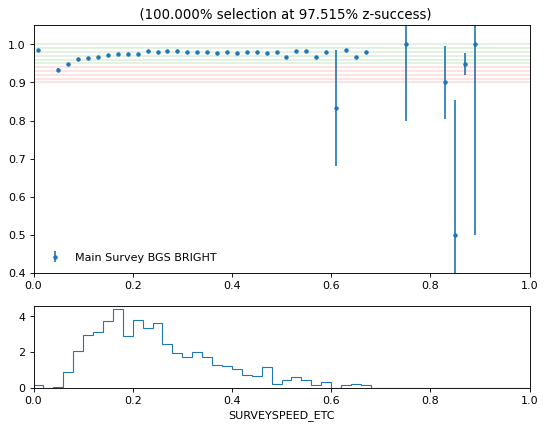

<ipython-input-292-be075ee2c30a>:18: RuntimeWarning: invalid value encountered in true_divide
  zfrac    = ng / ntot
<ipython-input-292-be075ee2c30a>:32: RuntimeWarning: invalid value encountered in true_divide
  axes[0].errorbar(bl, ng / ntot, el, fmt='o', label='Main Survey BGS {}'.format(ttype), markersize=3)


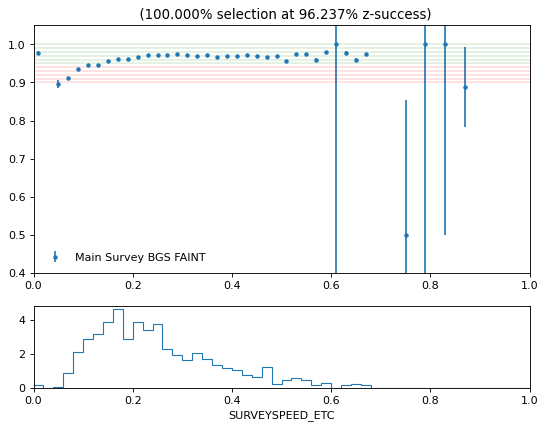

In [302]:
tsnr_zfrac(ztile_bgsbright, 'BRIGHT', xaxis='SURVEYSPEED_ETC')
tsnr_zfrac(ztile_bgsfaint,   'FAINT', xaxis='SURVEYSPEED_ETC')

<ipython-input-292-be075ee2c30a>:18: RuntimeWarning: invalid value encountered in true_divide
  zfrac    = ng / ntot
<ipython-input-292-be075ee2c30a>:32: RuntimeWarning: invalid value encountered in true_divide
  axes[0].errorbar(bl, ng / ntot, el, fmt='o', label='Main Survey BGS {}'.format(ttype), markersize=3)


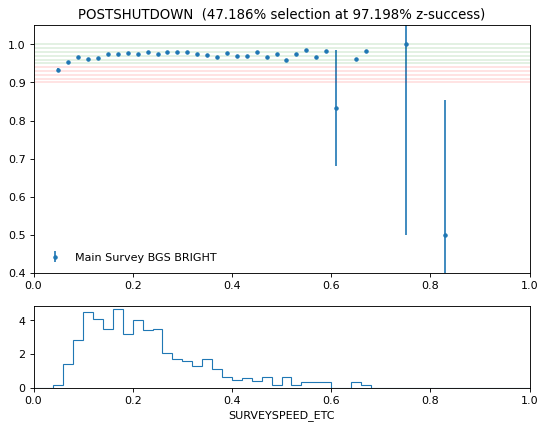

<ipython-input-292-be075ee2c30a>:18: RuntimeWarning: invalid value encountered in true_divide
  zfrac    = ng / ntot
<ipython-input-292-be075ee2c30a>:32: RuntimeWarning: invalid value encountered in true_divide
  axes[0].errorbar(bl, ng / ntot, el, fmt='o', label='Main Survey BGS {}'.format(ttype), markersize=3)


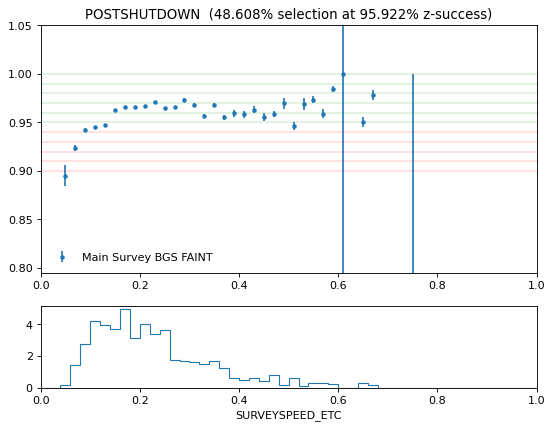

In [303]:
tsnr_zfrac(ztile_bgsbright, 'BRIGHT', sel=post_shutdown, title='POSTSHUTDOWN', xaxis='SURVEYSPEED_ETC')
tsnr_zfrac(ztile_bgsfaint, 'FAINT', sel=post_shutdown, title='POSTSHUTDOWN', xaxis='SURVEYSPEED_ETC')

# Done.